In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session|

In [10]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical


# Audio
import librosa
import librosa.display

# Plot
import matplotlib.pyplot as plt

# Utility
import glob
import numpy as np
from tqdm import tqdm
import IPython.display as ipd
from timeit import default_timer as timer

In [19]:
# upload the data
classes = pd.read_csv('archive/UrbanSound8K.csv')

In [20]:
classes_code = {v:k for k,v in zip(classes["class"], classes["classID"])}
# A dictionnary doesn't accept double values
print(classes_code)

{3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}


In [52]:
# glob는 파일들의 리스트를 뽑을 때 사용하는데, 파일의 경로명을 이용해서 입맛대로 요리할 수 있답니다. 
# 위의 glob() 함수는 인자로 받은 패턴과 이름이 일치하는 모든 파일과 디렉터리의 리스트를 반환합니다. 
# Building our dataset
dataset = list()
for folder in glob.glob('archive/all/'):
    list_sounds_path = glob.glob(folder+"//**")
    for elm in list_sounds_path:
        label = elm.split(".wav")[0][-5]
        if label == '-':
            label = elm.split(".wav")[0][-6]
        dataset.append({"file_name" : elm,
                       "label" : label})
        pass
    pass
pass
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state = 42)

In [53]:
dataset.head()

,file_name,label
6770,archive/all\54898-8-0-2.wav,8
3534,archive/all\172338-9-0-7.wav,9
8556,archive/all\95562-4-3-0.wav,4
7870,archive/all\75490-8-0-2.wav,8
1226,archive/all\128891-3-0-4.wav,3


In [54]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 42)

In [55]:
print(train.shape)
print(test.shape)

(6985, 2)
(1747, 2)


In [56]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    return mfccs

In [57]:
x_train = list()
y_train = list()
for i in tqdm(range(len(train))):
    x_train.append(extract_feature(train.file_name.iloc[i]))
    y_train.append(train.label.iloc[i])
    pass
pass

 13%|█▎        | 902/6985 [01:58<13:35,  7.46it/s]C:\Users\chldb\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
 78%|███████▊  | 5424/6985 [11:40<03:33,  7.32it/s]C:\Users\chldb\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
100%|██████████| 6985/6985 [14:56<00:00,  7.80it/s]


In [58]:
x_test = list()
y_test = list()
for i in tqdm(range(len(test))):
    x_test.append(extract_feature(test.file_name.iloc[i]))
    y_test.append(test.label.iloc[i])
    pass
pass

 25%|██▍       | 430/1747 [00:53<02:08, 10.27it/s]C:\Users\chldb\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
100%|██████████| 1747/1747 [03:40<00:00,  7.91it/s]


In [59]:
print("x_train",len(x_train),"y_train", len(y_train))

x_train 6985 y_train 6985


In [62]:
print("x_test",len(x_test),"y_test", len(y_test))

x_test 1747 y_test 1747


In [60]:
# Q. 주요 특성이 (40,173)인가?? 
X_train, Y_train = list(), list()
for x,y in zip(x_train,y_train):
    if x.shape == (40, 173):
        X_train.append(x)
        Y_train.append(y)
        pass
    pass
pass

In [61]:
X_test, Y_test = list(), list()
for x,y in zip(x_test,y_test):
    if x.shape == (40, 173):
        X_test.append(x)
        Y_test.append(y)
        pass
    pass
pass

In [63]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [64]:
print(X_train.shape)
print(X_test.shape)

(5846, 40, 173)
(1481, 40, 173)


In [65]:
# time : 전체 쉘에 대한 Wall time
# LabelEncoder() : 문자를 숫자(수치화), 숫자를 문자로 매핑
%%time
encoder = LabelEncoder()
encoder.fit(Y_train)

Y_train = encoder.transform(Y_train)
Y_test = encoder.transform(Y_test)

Wall time: 4 ms


In [66]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
Y_train1 = to_categorical(Y_train)
Y_test1 = to_categorical(Y_test)

In [84]:
X_test.shape

(1481, 40, 173, 1)

In [67]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(40, 173, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(10, activation='softmax'))

In [68]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [69]:
history = model.fit(X_train, Y_train1,
              batch_size=128,
              epochs=300,
              validation_data=(X_test, Y_test1),
              shuffle=True)

Epoch 1/300
46/46 [==============================] - 11s 227ms/step - loss: 3.8216 - accuracy: 0.1986 - val_loss: 2.0442 - val_accuracy: 0.2917
Epoch 2/300
46/46 [==============================] - 10s 222ms/step - loss: 1.7920 - accuracy: 0.3435 - val_loss: 1.7978 - val_accuracy: 0.4301
Epoch 3/300
46/46 [==============================] - 10s 214ms/step - loss: 1.5079 - accuracy: 0.4644 - val_loss: 1.5682 - val_accuracy: 0.5138
Epoch 4/300
46/46 [==============================] - 10s 224ms/step - loss: 1.3835 - accuracy: 0.5168 - val_loss: 1.4942 - val_accuracy: 0.5084
Epoch 5/300
46/46 [==============================] - 10s 226ms/step - loss: 1.2920 - accuracy: 0.5511 - val_loss: 1.3964 - val_accuracy: 0.5611
Epoch 6/300
46/46 [==============================] - 10s 215ms/step - loss: 1.2304 - accuracy: 0.5806 - val_loss: 1.3840 - val_accuracy: 0.5611
Epoch 7/300
46/46 [==============================] - 10s 211ms/step - loss: 1.1634 - accuracy: 0.6091 - val_loss: 1.3017 - val_accuracy:

46/46 [==============================] - 10s 226ms/step - loss: 0.3019 - accuracy: 0.8965 - val_loss: 0.4735 - val_accuracy: 0.8521
Epoch 58/300
46/46 [==============================] - 10s 225ms/step - loss: 0.3115 - accuracy: 0.8915 - val_loss: 0.4374 - val_accuracy: 0.8731
Epoch 59/300
46/46 [==============================] - 10s 219ms/step - loss: 0.3036 - accuracy: 0.8950 - val_loss: 0.4308 - val_accuracy: 0.8656
Epoch 60/300
46/46 [==============================] - 10s 219ms/step - loss: 0.2952 - accuracy: 0.8960 - val_loss: 0.4382 - val_accuracy: 0.8764
Epoch 61/300
46/46 [==============================] - 10s 229ms/step - loss: 0.3014 - accuracy: 0.8998 - val_loss: 0.4329 - val_accuracy: 0.8731
Epoch 62/300
46/46 [==============================] - 11s 234ms/step - loss: 0.2903 - accuracy: 0.9015 - val_loss: 0.4046 - val_accuracy: 0.8879
Epoch 63/300
46/46 [==============================] - 10s 225ms/step - loss: 0.2749 - accuracy: 0.9066 - val_loss: 0.4258 - val_accuracy: 0.879

46/46 [==============================] - 10s 217ms/step - loss: 0.1669 - accuracy: 0.9403 - val_loss: 0.4075 - val_accuracy: 0.8893
Epoch 114/300
46/46 [==============================] - 10s 217ms/step - loss: 0.1741 - accuracy: 0.9389 - val_loss: 0.3741 - val_accuracy: 0.9028
Epoch 115/300
46/46 [==============================] - 10s 216ms/step - loss: 0.1690 - accuracy: 0.9384 - val_loss: 0.4125 - val_accuracy: 0.8886
Epoch 116/300
46/46 [==============================] - 10s 218ms/step - loss: 0.1527 - accuracy: 0.9475 - val_loss: 0.3227 - val_accuracy: 0.9109
Epoch 117/300
46/46 [==============================] - 10s 219ms/step - loss: 0.1637 - accuracy: 0.9442 - val_loss: 0.3457 - val_accuracy: 0.9095
Epoch 118/300
46/46 [==============================] - 10s 215ms/step - loss: 0.1747 - accuracy: 0.9420 - val_loss: 0.3445 - val_accuracy: 0.9041
Epoch 119/300
46/46 [==============================] - 10s 218ms/step - loss: 0.1614 - accuracy: 0.9434 - val_loss: 0.3244 - val_accuracy:

46/46 [==============================] - 10s 220ms/step - loss: 0.1264 - accuracy: 0.9554 - val_loss: 0.3735 - val_accuracy: 0.9001
Epoch 170/300
46/46 [==============================] - 10s 220ms/step - loss: 0.1281 - accuracy: 0.9535 - val_loss: 0.3231 - val_accuracy: 0.9109
Epoch 171/300
46/46 [==============================] - 10s 221ms/step - loss: 0.1293 - accuracy: 0.9531 - val_loss: 0.3033 - val_accuracy: 0.9203
Epoch 172/300
46/46 [==============================] - 10s 219ms/step - loss: 0.1279 - accuracy: 0.9528 - val_loss: 0.3595 - val_accuracy: 0.9122
Epoch 173/300
46/46 [==============================] - 10s 220ms/step - loss: 0.1191 - accuracy: 0.9564 - val_loss: 0.3168 - val_accuracy: 0.9223
Epoch 174/300
46/46 [==============================] - 10s 218ms/step - loss: 0.1161 - accuracy: 0.9596 - val_loss: 0.3461 - val_accuracy: 0.9149
Epoch 175/300
46/46 [==============================] - 10s 220ms/step - loss: 0.1182 - accuracy: 0.9589 - val_loss: 0.3655 - val_accuracy:

46/46 [==============================] - 10s 221ms/step - loss: 0.0969 - accuracy: 0.9670 - val_loss: 0.3743 - val_accuracy: 0.9041
Epoch 226/300
46/46 [==============================] - 10s 219ms/step - loss: 0.1015 - accuracy: 0.9646 - val_loss: 0.3270 - val_accuracy: 0.9196
Epoch 227/300
46/46 [==============================] - 10s 221ms/step - loss: 0.1074 - accuracy: 0.9601 - val_loss: 0.3755 - val_accuracy: 0.9122
Epoch 228/300
46/46 [==============================] - 10s 221ms/step - loss: 0.1109 - accuracy: 0.9577 - val_loss: 0.3220 - val_accuracy: 0.9176
Epoch 229/300
46/46 [==============================] - 10s 220ms/step - loss: 0.1089 - accuracy: 0.9629 - val_loss: 0.3139 - val_accuracy: 0.9196
Epoch 230/300
46/46 [==============================] - 10s 222ms/step - loss: 0.0916 - accuracy: 0.9673 - val_loss: 0.3602 - val_accuracy: 0.9169
Epoch 231/300
46/46 [==============================] - 10s 219ms/step - loss: 0.0988 - accuracy: 0.9648 - val_loss: 0.3350 - val_accuracy:

46/46 [==============================] - 10s 220ms/step - loss: 0.0882 - accuracy: 0.9701 - val_loss: 0.3749 - val_accuracy: 0.9183
Epoch 282/300
46/46 [==============================] - 10s 222ms/step - loss: 0.0863 - accuracy: 0.9690 - val_loss: 0.4024 - val_accuracy: 0.9169
Epoch 283/300
46/46 [==============================] - 10s 222ms/step - loss: 0.0781 - accuracy: 0.9740 - val_loss: 0.3660 - val_accuracy: 0.9217
Epoch 284/300
46/46 [==============================] - 10s 218ms/step - loss: 0.0887 - accuracy: 0.9690 - val_loss: 0.3689 - val_accuracy: 0.9149
Epoch 285/300
46/46 [==============================] - 10s 222ms/step - loss: 0.0709 - accuracy: 0.9735 - val_loss: 0.3664 - val_accuracy: 0.9223
Epoch 286/300
46/46 [==============================] - 10s 220ms/step - loss: 0.0816 - accuracy: 0.9709 - val_loss: 0.4066 - val_accuracy: 0.9136
Epoch 287/300
46/46 [==============================] - 10s 221ms/step - loss: 0.0897 - accuracy: 0.9656 - val_loss: 0.3514 - val_accuracy:

Text(0.5, 1.0, 'Accuracy Curves')

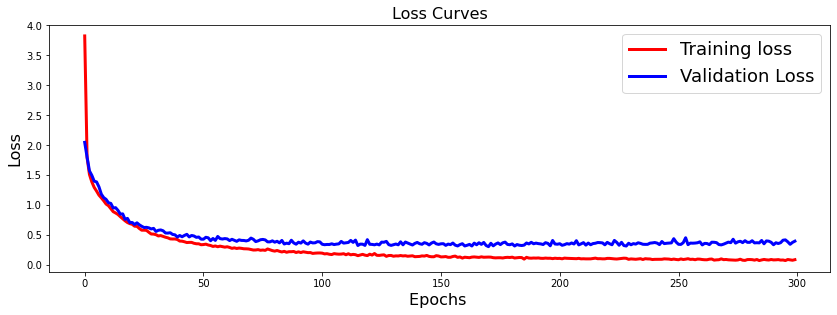

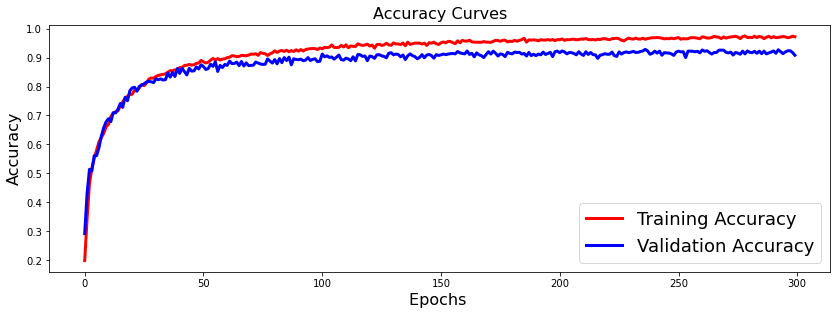

In [70]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [71]:
model_name = "urban_classification.h5"
model.save(model_name)
print('Saved trained model at %s ' % model_name)

Saved trained model at urban_classification.h5 


In [72]:
# verbose : 학습 과정에서 진행 내용을 출력하기 위한 모드를 설정
# 0은 출력 안함, 1은 진행바로 출력, 2는 각 epoch마다 한 줄씩 출력하라는 의미
predictions = model.predict(X_test, verbose=1)

47/47 [==============================] - 1s 11ms/step


In [73]:
# argmax : 다차원 배열의 경우에 차원에 따라 가장 큰 값의 인덱스들을 반환해주는 함수
print(np.argmax(predictions[0]))
print(Y_test[0])

7
7


In [74]:
scores = model.evaluate(X_test, Y_test1, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

47/47 [==============================] - 1s 12ms/step - loss: 0.3952 - accuracy: 0.9082
Test loss: 0.39518043398857117
Test accuracy: 0.9081701636314392


In [75]:
print(X_train.shape)

(5846, 40, 173, 1)


In [76]:
X_train2 = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
Y_train3 = to_categorical(Y_train)
Y_test3 = to_categorical(Y_test)

In [77]:
import keras
from keras.layers import GRU

input_shape = (40, 173)

model = keras.models.Sequential()
model.add(GRU(1025, input_shape=input_shape))
model.add(Dense(512, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation = "softmax"))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1025)              3690000   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               525312    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 4,282,266
Trainable params: 4,282,266
Non-trainable params: 0
_________________________________________________________________


In [78]:
history = model.fit(X_train2, Y_train3,
              batch_size=173,
              epochs=100,
              validation_data=(X_test2, Y_test3),
              shuffle=True)

Epoch 1/100
34/34 [==============================] - 36s 1s/step - loss: 1.8002 - accuracy: 0.3103 - val_loss: 1.5294 - val_accuracy: 0.4153
Epoch 2/100
34/34 [==============================] - 35s 1s/step - loss: 1.0791 - accuracy: 0.6185 - val_loss: 1.4864 - val_accuracy: 0.4564
Epoch 3/100
34/34 [==============================] - 35s 1s/step - loss: 0.6128 - accuracy: 0.8026 - val_loss: 1.5211 - val_accuracy: 0.5017
Epoch 4/100
34/34 [==============================] - 36s 1s/step - loss: 0.2505 - accuracy: 0.9317 - val_loss: 1.8139 - val_accuracy: 0.4801
Epoch 5/100
34/34 [==============================] - 36s 1s/step - loss: 0.1018 - accuracy: 0.9750 - val_loss: 2.0333 - val_accuracy: 0.4767
Epoch 6/100
34/34 [==============================] - 35s 1s/step - loss: 0.0547 - accuracy: 0.9853 - val_loss: 2.4310 - val_accuracy: 0.4659
Epoch 7/100
34/34 [==============================] - 35s 1s/step - loss: 0.0464 - accuracy: 0.9870 - val_loss: 2.2758 - val_accuracy: 0.4875
Epoch 8/100
3

34/34 [==============================] - 34s 998ms/step - loss: 2.8001e-05 - accuracy: 1.0000 - val_loss: 2.9694 - val_accuracy: 0.5192
Epoch 58/100
34/34 [==============================] - 34s 1s/step - loss: 2.6506e-05 - accuracy: 1.0000 - val_loss: 2.9747 - val_accuracy: 0.5192
Epoch 59/100
34/34 [==============================] - 34s 1000ms/step - loss: 2.5801e-05 - accuracy: 1.0000 - val_loss: 2.9784 - val_accuracy: 0.5206
Epoch 60/100
34/34 [==============================] - 34s 999ms/step - loss: 2.4502e-05 - accuracy: 1.0000 - val_loss: 2.9839 - val_accuracy: 0.5199
Epoch 61/100
34/34 [==============================] - 34s 991ms/step - loss: 2.3508e-05 - accuracy: 1.0000 - val_loss: 2.9883 - val_accuracy: 0.5192
Epoch 62/100
34/34 [==============================] - 34s 994ms/step - loss: 2.2793e-05 - accuracy: 1.0000 - val_loss: 2.9925 - val_accuracy: 0.5192
Epoch 63/100
34/34 [==============================] - 34s 996ms/step - loss: 2.1944e-05 - accuracy: 1.0000 - val_loss: 2.

Text(0.5, 1.0, 'Accuracy Curves')

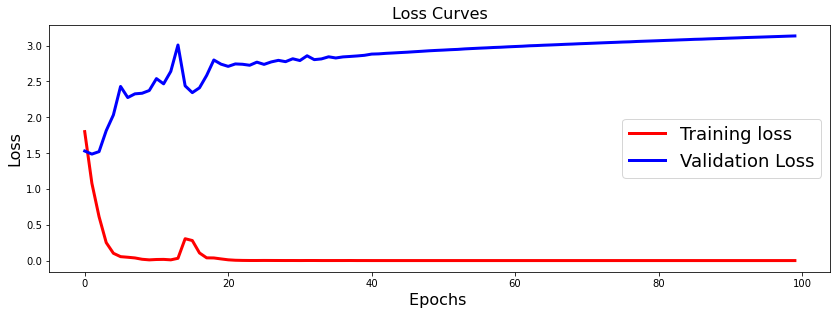

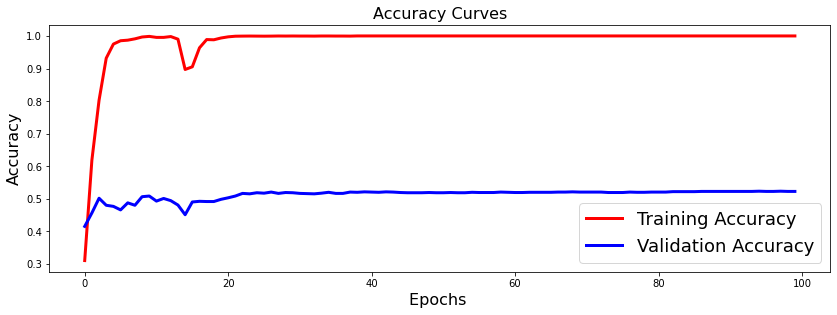

In [79]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [80]:
scores = model.evaluate(X_test2, Y_test3, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

47/47 [==============================] - 5s 102ms/step - loss: 3.1360 - accuracy: 0.5226
Test loss: 3.1359870433807373
Test accuracy: 0.5226198434829712
